In [2]:
import numpy as np
import pandas as pd
import random
import datetime as dt
import seaborn as sns
from re import search

random.seed(333)
pd.options.mode.chained_assignment = None

# 1. Análise Exploratória de Dados:

# 1.1 Dataframes & NAs

Como primeira etapa da EDA, gostaríamos de saber como são nossos dados e se há dados nulos no conjunto de dados.

Temos diferentes conjuntos de dados à nossa disposição:

- **holiday_events**: uma lista com todos os feriados e eventos equatorianos;
- **petróleo**: uma lista de preços do petróleo destinada a servir como um indicador econômico do Equador;
- **lojas**: um conjunto de dados com informações sobre nossas lojas: inclui cidade, estado, tipo e outros;
- **transações**: um conjunto de dados contendo o número de transações agregadas para cada loja em cada dia;
- **teste**: conjunto de teste geral de 16 dias de vendas que precisaremos prever;
- **trem**: um trem enorme com cerca de 4 anos de dados para prever nossos dados de vendas de teste.

Este notebook faz uso de todos os conjuntos de dados, exceto para os preços do petróleo.

In [4]:
# Carregando os datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.info())

# checkando se tem dados nulos:
test.isna().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None


id             False
date           False
store_nbr      False
family         False
onpromotion    False
dtype: bool

We have ID, date, store number, (product) family, saleprice and promotion columns.
Our train and test datasets have zero missing values.

In [11]:
# Saiba quantas lojas, produtos e datas estão em nossos dados:

train['store_nbr'].unique().__len__() # 54 lojas
train['family'].unique().__len__() # 33 produtos

len(train) / 54 / 33 # 1684 dias (entre 4 e 5 anos)
train['date'].iloc[0] # 2013-01-01 data inicial
train['date'].iloc[-1] # 2017-08-15 data final

len(test) / 54 / 33 # 16 dias
test['date'].iloc[0] # 2017-08-16 data inicial do teste
test['date'].iloc[-1] # 2017-08-31 data final do teste

'2017-08-31'

Nossos principais conjuntos de dados consistem em:

- **54 lojas**

- **33 grupos de produtos**


Somos solicitados a prever as vendas de cada grupo de produtos (33), em cada loja (54), durante 16 dias consecutivos.
Isso significa que teremos que fazer 33 * 54 * 16 = 28512 previsões. Para tornar isso mais gerenciável, podemos criar um quadro de dados e previsões para cada grupo de produtos individual. Isso significa que criaremos 33 quadros de dados, cada um fazendo 864 previsões.

Para um tempo de execução mais rápido e uma melhor supervisão, primeiro criaremos quadros de dados diferentes que, em seguida, mesclaremos por meio de um pipeline em 33 quadros de dados de produtos individuais.

# 1.2 Visualização

Como vamos criar um dataframe por produto, o melhor é criar um gráfico para ver a evolução das vendas de cada família ao longo dos anos. Queremos a soma das vendas de cada mês, de cada ano, de cada família, então agregamos de acordo.

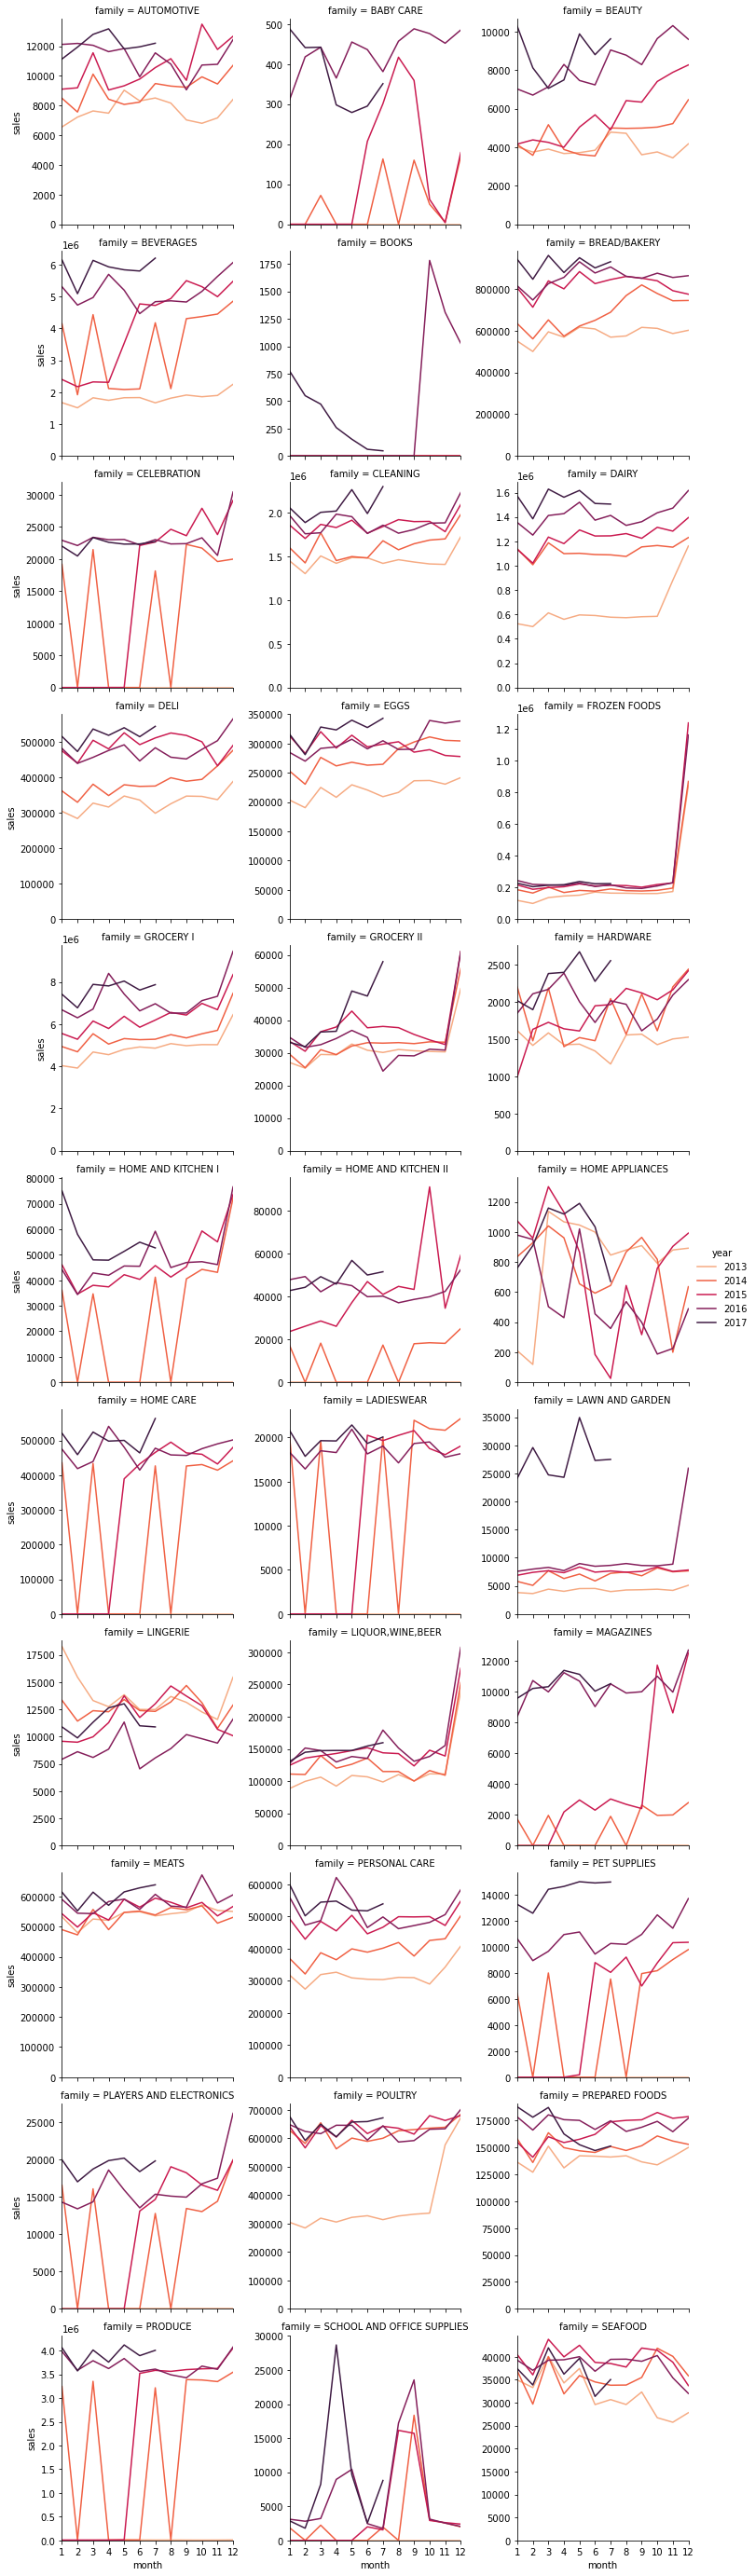

In [12]:
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month

monthly_sales = train.groupby(['family', 'year','month']).agg({"sales" : "sum"}).reset_index()

# O valor do último mês (para cada 33 produtos) mudamos para nulo, senão distorcerá
# o gráfico já que os dados deste mês estão incompletos:
for x in range(33):
    z = 55+(x*56)
    monthly_sales.at[z,'sales'] = np.nan 

# Usamos Seaborn FacetGrid com um col_wrap de 3 para mostrar todos os gráficos em linhas de três. 
# Também precisamos de sharey = False para que o eixo y de todos os gráficos não seja compartilhado, mas individual.
product_lineplots = sns.FacetGrid(monthly_sales, col="family", hue='year', sharey=False, height=3.5, col_wrap=3, palette='rocket_r')
product_lineplots.map(sns.lineplot, "month", 'sales')
product_lineplots.add_legend()
product_lineplots.set(xlim=(1, 12), ylim=(0, None), xticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

*Algumas observações:*

Alguns meses mostram um comportamento estranho para alguns de nossos produtos (por exemplo Pet Supplies, Produce,...):
- 2014: fev(2), abr(4), maio(5), jun(6), ago(8)
- 2015: jan(1), fev(2), mar(3), abr(4), maio(5)

**Dezembro:**

Parece ser o melhor mês de vendas para muitos produtos, provavelmente por ser um período de férias tanto no natal quanto no réveillon.

**Livros:**

Parece que a categoria 'livros' está prestes a ser desativada, provavelmente é uma boa ideia definir essa previsão como zero.

**Material escolar e de escritório:**

Parece atingir o pico em abril, mas antes deste ano mais em agosto-setembro. Essas datas são particularmente interessantes para nós, pois nossa previsão também ocorre no meio desse pico (final de agosto).

[(1.0, 12.0),
 (0.0, 30639353.96948254),

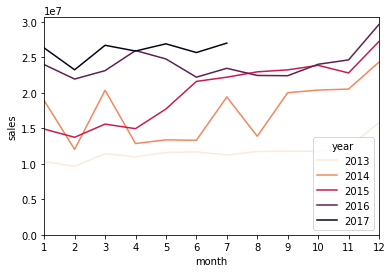

In [13]:
# Crie um gráfico para todas as vendas:

total_monthly_sales = train.groupby(['year','month']).agg({"sales" : "sum"}).reset_index()

total_monthly_sales.at[55,'sales'] = np.nan

total_plot = sns.lineplot(x='month', y='sales', hue='year', palette='rocket_r', data=total_monthly_sales)
total_plot.set(xlim=(1, 12), ylim=(0, None), xticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

# 1.3 Criação de variáveis

Nós vamos criar:

- Um dataframe ***independente***: onde um dia = uma linha, independente de números de lojas e grupos de produtos, aqui criamos variáveis que dependem da data, irrelevantes da loja (por exemplo, o dia da semana )

- Um dataframe ***todas as lojas***: criamos um dataframe onde agregamos todas as 54 lojas e adicionamos variáveis que dependem das lojas (por exemplo: store_closed)

- Um ***grupo de dataframes de produtos***: o dataframe principal onde agregamos por produto e depois adicionamos os dados criados anteriormente do df independente e de todas as lojas df.

# 1.3.1 Estrutura de dados independente

Para o dataframe **independente**, criamos as seguintes funções:
- **create_date_df**: pequena função para agregar o dataframe em um menor agrupado por data

- **create_paydays**: para os empregos do governo (o maior empregador do Equador), os salários são pagos no primeiro dia do mês e no dia 15. Essa função cria as colunas do dia de pagamento: tanto os dias de pagamento efetivos quanto uma escala que conta para ter uma var que mostra há quanto tempo as pessoas foram pagas.

- **onehotencode**: função para transformar as colunas escolhidas em diferentes colunas binárias (também usaremos esta função para todas as nossas lojas df).

- **pipeline independente**: pipeline que mescla todas as funções anteriores para criar um dataframe. Aqui também adicionamos variáveis extras: variáveis de data regular, uma variável que indica quando o terremoto aconteceu e uma variável para quando a escola começa (para aumentar nossa pontuação de material escolar e de escritório).

In [14]:
def create_date_df(df, store_nr):

    single_store_df = df[df['store_nbr'] == store_nr]
    single_store_series = single_store_df.groupby(["date"]).sum(numeric_only=True)

    return single_store_series

In [15]:
def create_payday_anchors(df):

    df.reset_index(inplace=True)
    df['Payday'] = 0

    for id, row in df.iterrows():

        if search('-01$', row['date']):
            df.at[id - 1, 'Payday'] = 1

        if search('-15$', row['date']):
            df.at[id, 'Payday'] = 1

    df = df[:-1]

    return df

In [16]:
def onehotencode(df, list_of_variables):

    column_name_list = list()
    my_category_list = list()

    for column in list_of_variables:

        categories = df[column].unique().tolist()

        for i in categories:

            this_list = ((df[column] == i) * 1).tolist()

            column_name_list.append(column + str(i))
            my_category_list.append(this_list)

            print('Finished ' + str(i))

        print(str(column) + ' is done.')

    onehotencode_df = pd.DataFrame(my_category_list).transpose()
    onehotencode_df.columns = np.asarray(column_name_list)

    return onehotencode_df

In [21]:
def independant_pipeline():

    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')

    # Get one store one product DF:
    one_store_df = create_date_df(train, 1)
    one_store_df_test = create_date_df(test, 1)
    one_store_df.drop('sales', axis=1, inplace=True)

    one_store_df = pd.concat([one_store_df, one_store_df_test])

    del train
    del test

    
    # Adicionar dias de pagamento

    one_store_df = create_payday_anchors(one_store_df)

    payday_series = one_store_df['Payday']
    payday_count = 0
    payday_scale_list = list()

    for x in range(payday_series.__len__()):

        if payday_series[x] == 1:
            payday_count = 0
            payday_scale_list.append(payday_count)
        else:
            payday_count += 1
            payday_scale_list.append(payday_count)

    one_store_df['Payday_Scale'] = payday_scale_list

    one_store_df.drop(['id'], axis=1, inplace=True)

    # Adicionando variáveis de data

    dayoftheweek_list = list()
    dayoftheyear_list = list()
    monthoftheyear_list = list()
    year_list = list()

    for x in range(1700): # because 1700 different days

        thisdate = one_store_df['date'][x]
        thisdayoftheweek = dt.datetime.strptime(thisdate, '%Y-%m-%d').strftime('%A')
        thisdayoftheyear = dt.datetime.strptime(thisdate, '%Y-%m-%d').strftime('%j')
        thismonthoftheyear = dt.datetime.strptime(thisdate, '%Y-%m-%d').strftime('%B')
        thisyear = dt.datetime.strptime(thisdate, '%Y-%m-%d').strftime('%Y')

        dayoftheweek_list.append(thisdayoftheweek)
        dayoftheyear_list.append(thisdayoftheyear)
        monthoftheyear_list.append(thismonthoftheyear)
        year_list.append(thisyear)

    one_store_df['DayOfTheWeek'] = dayoftheweek_list
    one_store_df['DayOfTheYear'] = dayoftheyear_list
    one_store_df['MonthOfTheYear'] = monthoftheyear_list
    one_store_df['Year'] = year_list

    one_store_df['DayOfTheYear'] = pd.to_numeric(one_store_df['DayOfTheYear'])

    # Convert DayOfTheWeek to numeric:

    dayoftheweek_scale_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4,
                               'Friday': 5, 'Saturday': 6, 'Sunday': 7}

    one_store_df['dayoftheweek_scale'] = one_store_df['DayOfTheWeek'].map(dayoftheweek_scale_dict)

    # OneHotEncode  

    onehotcolumnlist = ('DayOfTheWeek', 'MonthOfTheYear', 'Year')
    onehotencode_df = onehotencode(one_store_df, onehotcolumnlist)
    one_store_df = pd.concat([one_store_df, onehotencode_df], axis=1)


    # Drop Some Cols      

    one_store_df.drop(['store_nbr', 'DayOfTheWeek', 'onpromotion'], axis=1, inplace=True)

    return one_store_df

In [22]:
# ---Pipeline --- #

independant_df = independant_pipeline()

Finished Tuesday
Finished Wednesday
Finished Thursday
Finished Friday
Finished Saturday
Finished Sunday
Finished Monday
DayOfTheWeek is done.
Finished January
Finished February
Finished March
Finished April
Finished May
Finished June
Finished July
Finished August
Finished September
Finished October
Finished November
Finished December
MonthOfTheYear is done.
Finished 2013
Finished 2014
Finished 2015
Finished 2016
Finished 2017
Year is done.


# 1.3.2 Dataframe de todas as lojas

Para nosso dataframe **todas as lojas**, criamos as seguintes funções:
- **create_multi_store_one_product_df**: pequena função para criar um df agregado em lojas e filtrado em um produto.

- **create_holiday_variables**: função que cria todas as diferentes variáveis de férias (dependendo da localização da loja).

- **create_location_variables**: função que cria algumas variáveis extras com base nas localizações das lojas. Estes são dados externos que adicionamos e que não estavam disponíveis em nossos dataframes iniciais no kaggle. Analisamos especificamente a elevação (o Equador é um país montanhoso) e a densidade da cidade (uma loja em uma cidade grande pode ter efeitos muito diferentes em determinados momentos do que uma loja em uma cidade pouco povoada).

- **all_stores_pipeline**: função de pipeline que mescla as funções anteriores (e também executa onehotencode) para criar todas as nossas lojas df.

In [23]:
def create_multi_store_one_product_df(df, product_name):

    multistore_single_product = df[df['family'] == product_name]

    return multistore_single_product

In [24]:
def create_holiday_variables(df):

    holidays = pd.read_csv('holidays_events.csv')

    holidays = holidays[holidays['transferred'] == False]
    holidays['holiday_type'] = holidays['type']
    holidays.drop(['transferred', 'description', 'type'], axis=1, inplace=True)

    national_holidays = holidays[holidays['locale'] == 'National']
    national_holidays['national_holiday_type'] = national_holidays['holiday_type']
    national_holidays.drop(['locale', 'locale_name', 'holiday_type'], axis=1, inplace=True)
    national_holidays.drop_duplicates(subset='date', keep="first", inplace=True)
    df = pd.merge(df, national_holidays, how='left', on=['date'])

    state_holidays = holidays[holidays['locale'] == 'Regional']
    state_holidays['state'] = state_holidays['locale_name']
    state_holidays['state_holiday_type'] = state_holidays['holiday_type']
    state_holidays.drop(['locale', 'locale_name', 'holiday_type'], axis=1, inplace=True)
    df = pd.merge(df, state_holidays, how='left', on=['date', 'state'])

    city_holidays = holidays[holidays['locale'] == 'Local']
    city_holidays['city'] = city_holidays['locale_name']
    city_holidays['city_holiday_type'] = city_holidays['holiday_type']
    city_holidays.drop(['locale', 'locale_name', 'holiday_type'], axis=1, inplace=True)
    city_holidays.drop([265], axis=0, inplace=True)
    df = pd.merge(df, city_holidays, how='left', on=['date', 'city'])

    df['holiday_type'] = np.nan
    df['holiday_type'] = df['holiday_type'].fillna(df['national_holiday_type'])
    df['holiday_type'] = df['holiday_type'].fillna(df['state_holiday_type'])
    df['holiday_type'] = df['holiday_type'].fillna(df['city_holiday_type'])
    df.drop(['national_holiday_type', 'state_holiday_type', 'city_holiday_type'], axis=1, inplace=True)

    return df

In [25]:
def create_location_variables(df):

    stores = pd.read_csv('stores.csv')

    # stores['city'].unique()
    # ['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
    #  'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
    #  'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
    #  'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen']

    # Height dict:
    Height = {'Quito': 2850, 'Santo Domingo': 550, 'Cayambe': 2830, 'Latacunga': 2860,
              'Riobamba': 2754, 'Ibarra': 2225, 'Guaranda': 2668, 'Puyo': 950,
              'Ambato': 2577, 'Guayaquil': 0, 'Salinas': 0, 'Daule': 0,
              'Babahoyo': 0, 'Quevedo': 75, 'Playas': 0, 'Libertad': 36,
              'Cuenca': 2560, 'Loja': 2060, 'Machala': 0, 'Esmeraldas': 15,
              'Manta': 0, 'El Carmen': 250}

    # Elevation:
    # 0 = 0 - 200 (10)
    # 1 = 200-700 (2)
    # 2 = 700-1500 (1)
    # 3 = 1500-2300 (2)
    # 4 = 2300-3000 (7)

    Population = {'Quito': 2000000, 'Santo Domingo': 460000, 'Cayambe': 40000, 'Latacunga': 100000,
                  'Riobamba': 157000, 'Ibarra': 150000, 'Guaranda': 35000, 'Puyo': 40000,
                  'Ambato': 350000, 'Guayaquil': 2750000, 'Salinas': 50000, 'Daule': 130000,
                  'Babahoyo': 105000, 'Quevedo': 200000, 'Playas': 40000, 'Libertad': 105000,
                  'Cuenca': 445000, 'Loja': 200000, 'Machala': 260000, 'Esmeraldas': 200000,
                  'Manta': 240000, 'El Carmen': 120000}

    # Population:
    # 0 = 0-60000 (5)
    # 1 = 60000-160000 (12)
    # 2 = 160000-280000 (3)
    # 3 = 280000+ (2)

    Size = {'Quito': 372, 'Santo Domingo': 60, 'Cayambe': 378, 'Latacunga': 370,
            'Riobamba': 59, 'Ibarra': 242, 'Guaranda': 520, 'Puyo': 88,
            'Ambato': 47, 'Guayaquil': 345, 'Salinas': 27, 'Daule': 475,
            'Babahoyo': 175, 'Quevedo': 300, 'Playas': 280, 'Libertad': 28,
            'Cuenca': 71, 'Loja': 44, 'Machala': 67, 'Esmeraldas': 70,
            'Manta': 60, 'El Carmen': 1250}

    stores["City_Population"] = stores['city'].map(Population)
    stores["City_Elevation"] = stores['city'].map(Height)
    stores["City_Size"] = stores['city'].map(Size)
    stores["City_Density"] = round(stores["City_Population"] / stores["City_Size"],0)
    stores["City_Population_Category"] = 0
    stores["City_Elevation_Category"] = 0
    stores["City_Size_Category"] = 0
    stores["City_Density_Category"] = 0

    for id, row in stores.iterrows():

        if row['City_Elevation'] < 200:
            stores.at[id, 'City_Elevation_Category'] = 0
        elif row['City_Elevation'] < 700:
            stores.at[id, 'City_Elevation_Category'] = 1
        elif row['City_Elevation'] < 1500:
            stores.at[id, 'City_Elevation_Category'] = 2
        elif row['City_Elevation'] < 2300:
            stores.at[id, 'City_Elevation_Category'] = 3
        else:
            stores.at[id, 'City_Elevation_Category'] = 4

        if row['City_Population'] < 60000:
            stores.at[id, 'City_Population_Category'] = 0
        elif row['City_Population'] < 160000:
            stores.at[id, 'City_Population_Category'] = 1
        elif row['City_Population'] < 280000:
            stores.at[id, 'City_Population_Category'] = 2
        else:
            stores.at[id, 'City_Population_Category'] = 3

        if row['City_Size'] < 150:
            stores.at[id, 'City_Size_Category'] = 0
        elif row['City_Size'] < 325:
            stores.at[id, 'City_Size_Category'] = 1
        elif row['City_Size'] < 1000:
            stores.at[id, 'City_Size_Category'] = 2
        else:
            stores.at[id, 'City_Size_Category'] = 3

        if row['City_Density'] < 150:
            stores.at[id, 'City_Density_Category'] = 0
        elif row['City_Density'] < 325:
            stores.at[id, 'City_Density_Category'] = 1
        elif row['City_Density'] < 1000:
            stores.at[id, 'City_Density_Category'] = 2
        elif row['City_Density'] < 3000:
            stores.at[id, 'City_Density_Category'] = 3
        elif row['City_Density'] < 7000:
            stores.at[id, 'City_Density_Category'] = 4
        else:
            stores.at[id, 'City_Density_Category'] = 5

    city_variables_df = stores[['store_nbr', 'City_Elevation_Category', 'City_Population_Category', 'City_Size_Category',
                                'City_Density_Category', 'City_Density']]
    df = pd.merge(df, city_variables_df, how='left', on='store_nbr')
    df.drop(['city','state'], axis=1, inplace=True)

    return df

In [26]:
def all_stores_pipeline():

    originaltrainFull = pd.read_csv('train.csv')
    originaltest = pd.read_csv('test.csv')

    stores = pd.read_csv('stores.csv')
    transactions = pd.read_csv('transactions.csv')

    all_stores_df = create_multi_store_one_product_df(originaltrainFull, 'AUTOMOTIVE')
    all_stores_df_test = create_multi_store_one_product_df(originaltest, 'AUTOMOTIVE')
    all_stores_df.drop('sales', axis=1, inplace=True)

    all_stores_df = pd.concat([all_stores_df, all_stores_df_test])
    all_stores_df.drop(['id', 'family', 'onpromotion'], axis=1, inplace=True)

    all_stores_df = pd.merge(all_stores_df, stores, how='left', on=['store_nbr'])

    del originaltest
    del originaltrainFull

    # Adicionar variáveis de feriado

    all_stores_df = create_holiday_variables(all_stores_df)

    # Adicionar variáveis de localização

    all_stores_df = create_location_variables(all_stores_df)

    # Criar variável de loja fechada

    all_stores_df = pd.merge(all_stores_df, transactions, how='left', on=['date', 'store_nbr'])
    all_stores_df['transactions'].fillna(0, inplace=True)

    store_closed = [1 if x == 0 else 0 for x in all_stores_df['transactions']]

    all_stores_df['store_closed'] = store_closed
    all_stores_df['store_closed'].iloc[-864:] = 0

    all_stores_df.drop('transactions', axis=1, inplace=True)

    # OneHotEncode

    all_stores_df['isholiday'] = 1
    thislist = all_stores_df['holiday_type'].isna()
    all_stores_df.loc[thislist,'isholiday'] = 0

    onehotcolumnlist = ('store_nbr', 'type', 'cluster', 'holiday_type', 'City_Elevation_Category',
                        'City_Population_Category', 'City_Density_Category', 'City_Size_Category')

    onehotencode_df = onehotencode(all_stores_df, onehotcolumnlist)
    all_stores_df = pd.concat([all_stores_df, onehotencode_df], axis=1)

    # Drop Some Cols

    all_stores_df.drop(['type', 'cluster', 'holiday_type'], axis=1, inplace=True)

    return all_stores_df

In [27]:
# --- Pipeline --- #

all_stores_df = all_stores_pipeline()

Finished 1
Finished 10
Finished 11
Finished 12
Finished 13
Finished 14
Finished 15
Finished 16
Finished 17
Finished 18
Finished 19
Finished 2
Finished 20
Finished 21
Finished 22
Finished 23
Finished 24
Finished 25
Finished 26
Finished 27
Finished 28
Finished 29
Finished 3
Finished 30
Finished 31
Finished 32
Finished 33
Finished 34
Finished 35
Finished 36
Finished 37
Finished 38
Finished 39
Finished 4
Finished 40
Finished 41
Finished 42
Finished 43
Finished 44
Finished 45
Finished 46
Finished 47
Finished 48
Finished 49
Finished 5
Finished 50
Finished 51
Finished 52
Finished 53
Finished 54
Finished 6
Finished 7
Finished 8
Finished 9
store_nbr is done.
Finished D
Finished C
Finished B
Finished E
Finished A
type is done.
Finished 13
Finished 15
Finished 6
Finished 7
Finished 3
Finished 12
Finished 16
Finished 9
Finished 1
Finished 10
Finished 8
Finished 2
Finished 4
Finished 5
Finished 11
Finished 14
Finished 17
cluster is done.
Finished Holiday
Finished nan
Finished Work Day
Finished Addi

# 1.3.3 Estruturas de dados do produto

A última etapa da nossa fase de criação de variáveis é criar 33 dataframes de **produto**. Criamos um pipeline que integra nossos dataframes **independentes** e **todas as lojas**.

In [28]:
def full_product_pipeline(family, independant_df=independant_df, all_stores_df=all_stores_df):

    originaltrainFull = pd.read_csv('train.csv')
    originaltest = pd.read_csv('test.csv')

    multistore_product = create_multi_store_one_product_df(originaltrainFull, family)

    # merge com o test
    multistore_product_test = create_multi_store_one_product_df(originaltest, family)
    multistore_product_test['sales'] = np.nan

    del originaltrainFull
    del originaltest

    # tomar log de vendas:
    multistore_product['sales'] = np.log1p(multistore_product['sales']+1)

    msp_full = pd.concat([multistore_product, multistore_product_test])

    # reset index:
    msp_full.reset_index(inplace=True, drop=True)

    # Adicionar DF independente

    msp_full = pd.merge(msp_full, independant_df, how='left', on=['date'])

    # Adicionar todas as lojas DF

    msp_full = pd.merge(msp_full, all_stores_df, how='left', on=['date', 'store_nbr'])

    # Add Earthquake Info

    earthquake_day = [1 if x == '2016-04-16' else 0 for x in msp_full['date']]
    earthquake_impact = [1 if (x > '2016-04-16') & (x < '2016-05-16') else 0 for x in msp_full['date']]

    msp_full['earthquake_day'] = earthquake_day
    msp_full['earthquake_impact'] = earthquake_impact

    # Add School Info

    school_preparation = [1 if (x > '2014-09-15') & (x < '2014-10-15') or (x > '2015-09-15') & (x < '2015-10-15')
                          or (x > '2016-09-15') & (x < '2016-10-15') or (x > '2017-09-15') & (x < '2017-10-15')
                          else 0 for x in msp_full['date']]

    msp_full['school_preparation'] = school_preparation

    # Limpe o DF antes de modelar

    msp_full.drop(['family', 'MonthOfTheYear'], axis=1, inplace=True)

    return msp_full

In [31]:
# --- Executar Pipeline de Produto Completo para cada produto --- #

# Listar todas as famílias de produtos:

list_of_families = ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                    'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
                    'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
                    'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
                    'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
                    'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
                    'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
                    'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
                    'SEAFOOD']

# Crie um novo .csv para cada família de produtos:

for x in list_of_families:

    this_df = full_product_pipeline(x)

    if x == 'BREAD/BAKERY':

            x = 'BREADBAKERY'

    print('Completed eda for ' + str(x))
    this_df.to_csv('Competicao'+str(x)+'.csv', index=False)

Completed eda for AUTOMOTIVE
Completed eda for BABY CARE
Completed eda for BEAUTY
Completed eda for BEVERAGES
Completed eda for BOOKS
Completed eda for BREADBAKERY
Completed eda for CELEBRATION
Completed eda for CLEANING
Completed eda for DAIRY
Completed eda for DELI
Completed eda for EGGS
Completed eda for FROZEN FOODS
Completed eda for GROCERY I
Completed eda for GROCERY II
Completed eda for HARDWARE
Completed eda for HOME AND KITCHEN I
Completed eda for HOME AND KITCHEN II
Completed eda for HOME APPLIANCES
Completed eda for HOME CARE
Completed eda for LADIESWEAR
Completed eda for LAWN AND GARDEN
Completed eda for LINGERIE
Completed eda for LIQUOR,WINE,BEER
Completed eda for MAGAZINES
Completed eda for MEATS
Completed eda for PERSONAL CARE
Completed eda for PET SUPPLIES
Completed eda for PLAYERS AND ELECTRONICS
Completed eda for POULTRY
Completed eda for PREPARED FOODS
Completed eda for PRODUCE
Completed eda for SCHOOL AND OFFICE SUPPLIES
Completed eda for SEAFOOD


## 2 - Modelagem

Para modelagem, **LGBMR** parece dar os melhores resultados.

Você pode testar o modelo em um conjunto de validação ou em várias dobras de validação cruzada.
Principalmente pela velocidade, optei por testar em apenas um conjunto de validação 16 dias antes do período de previsão real.
Isso não é ideal e pode sobreajustar um pouco, pois é apenas um conjunto de teste, mas como o conjunto de validação está próximo do conjunto real, deve ser um pouco representativo do nosso teste kaggle.

Criamos algumas funções de suporte para apoiar nossa jornada de modelagem:

- **scorethis_rmsle**: esta função pontua uma previsão com um conjunto de verdades básicas da mesma forma que esta competição está sendo pontuada pelo kaggle (usando rmsle).

- **create_validation**: isso cria nosso teste de validação e conjuntos de treinamento, juntamente com as verdades básicas. Treine, treine_y, teste e teste_y, respectivamente. Se validação=False, então esta função cria train, train_y e test que podemos usar para nossa submissão.

- **lgbmr_run**: esta função executa nosso modelo lgbmr escolhido. Ele tem dois modos: 'validação' se você deseja executar no conjunto de validação ou 'envio' se deseja executá-lo para um envio kaggle.

- **execute_validation**: executa o modelo escolhido em cada um dos dataframes do produto.

In [32]:
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor

sample_submission = pd.read_csv('sample_submission.csv')

In [33]:
def scorethis_rmsle(prediction_list, y_list):

    scorelist = list()

    for x in range(prediction_list.__len__()):


        log_score_x = np.abs(np.abs(prediction_list[x]) - np.abs(y_list[x]))
        
        try:
            [scorelist.append(y) for y in log_score_x.values]
        except:
            scorelist.append(log_score_x)

    score_array = np.array(scorelist)

    rmsle = np.sqrt(np.mean(score_array**2)) # quadrado da média da potência da diferença dos logs
    rmsle = np.round(rmsle, 3)

    return rmsle

In [34]:
def create_validation(this_family_df, validation=True):
    
    if validation is True:
    
        this_family_df = this_family_df[:-864]
        # Remova as 864 principais linhas de envio se for para validação
    
    this_family_sales = this_family_df['sales']

    this_family_df.drop(['sales', 'date'], axis=1, inplace=True)

    scaler = MinMaxScaler()
    this_family_df[this_family_df.columns] = scaler.fit_transform(this_family_df[this_family_df.columns])


    test = this_family_df.iloc[-864:]
    test_y = this_family_sales.iloc[-864:]

    train = this_family_df.iloc[:-864]
    train_y = this_family_sales.iloc[:-864]

    return train, train_y, test, test_y

In [35]:
def lgbmr_run(train, train_y, test, test_y,
           validation=True):

    lgbmr_model = LGBMRegressor(
        colsample_bytree=0.7,
        learning_rate=0.055,
        min_child_samples=10,
        num_leaves=19,
        objective='regression',
        n_estimators=1000,
        n_jobs=4,
        random_state=337)

    lgbmr_model.fit(train, train_y)
    lgbmr_pred = lgbmr_model.predict(test).tolist()
    lgbmr_pred = [round(x, 2) for x in lgbmr_pred]
    
    if validation == True:
        
        # conjunto de validação também possui verdades básicas:
        test_y = test_y.to_list()

        return lgbmr_pred, test_y

    else:

        return lgbmr_pred

In [36]:
def execute_validation(thisfunc):

    double_list_of_predictions = []
    double_list_of_ground_truths = []

    for x in list_of_families: # 33
        
        if x == 'BREAD/BAKERY':

            x = 'BREADBAKERY'
            # Caso contrário, criaria um erro ao procurar o diretório BREAD/ em vez do arquivo

        print('Evaluating '+str(x)+'...')
        
        this_df = pd.read_csv('Competicao' + str(x) + '.csv')

        train, train_y, test, test_y = create_validation(this_df)
        pred, y = thisfunc(train, train_y, test, test_y, validation=True)
        
        if x == 'BOOKS':

            zero_list = []

            for g in range(864):

                zero_list.append(0.6931471805599453) 
                # isso será exatamente 0 quando transformarmos nossas previsões novamente
                # antes de logarmos (vendas +1)

            double_list_of_predictions.append(zero_list)
            double_list_of_ground_truths.append(y) 
            
        else:
            
            double_list_of_predictions.append(pred) # 33 * [864]
            double_list_of_ground_truths.append(y) # 33 * [864]

    list_of_predictions = list()
    list_of_ground_truths = list()

    for x in double_list_of_predictions:
        for y in x:
            list_of_predictions.append(y) # desempacotar 33 * 864

    for x in double_list_of_ground_truths:
        for z in x:
            list_of_ground_truths.append(z) # desempacotar 33 * 864

    return list_of_predictions, list_of_ground_truths

In [37]:
# --- Executando modelo LGGBMR no conjunto de validação --- #

list_of_lgbmr_predictions, list_of_ground_truths = execute_validation(lgbmr_run)
scorethis_rmsle(list_of_lgbmr_predictions, list_of_ground_truths)

Evaluating AUTOMOTIVE...
Evaluating BABY CARE...
Evaluating BEAUTY...
Evaluating BEVERAGES...
Evaluating BOOKS...
Evaluating BREADBAKERY...
Evaluating CELEBRATION...
Evaluating CLEANING...
Evaluating DAIRY...
Evaluating DELI...
Evaluating EGGS...
Evaluating FROZEN FOODS...
Evaluating GROCERY I...
Evaluating GROCERY II...
Evaluating HARDWARE...
Evaluating HOME AND KITCHEN I...
Evaluating HOME AND KITCHEN II...
Evaluating HOME APPLIANCES...
Evaluating HOME CARE...
Evaluating LADIESWEAR...
Evaluating LAWN AND GARDEN...
Evaluating LINGERIE...
Evaluating LIQUOR,WINE,BEER...
Evaluating MAGAZINES...
Evaluating MEATS...
Evaluating PERSONAL CARE...
Evaluating PET SUPPLIES...
Evaluating PLAYERS AND ELECTRONICS...
Evaluating POULTRY...
Evaluating PREPARED FOODS...
Evaluating PRODUCE...
Evaluating SCHOOL AND OFFICE SUPPLIES...
Evaluating SEAFOOD...


0.337

Algumas observações após mais testes:

- Esta pontuação é de 0,337, que é a melhor pontuação que obtive no conjunto de validação
- outros hiperparâmetros no mesmo modelo pontuam +0,338
- outros modelos marcam 0,358 (XGB) a 0,423 (Lasso) na validação

# 2.2 Envio do Kaggle

Agora vamos executar o mesmo modelo **LGBM** que testamos, em nosso conjunto de envio kaggle.

In [39]:
def execute_submission(thisfunc):

    list_of_predictions = []

    for x in list_of_families:
        
        if x == 'BREAD/BAKERY':

            x = 'BREADBAKERY'

        print('Evaluating '+str(x)+'...')
        this_df = pd.read_csv('Competicao' + str(x) + '.csv')
        
        if x == 'BOOKS':

            zero_list = []

            for g in range(864):

                zero_list.append(0.6931471805599453) 

            list_of_predictions.append(zero_list)

        else:
    
            train, train_y, test, test_y = create_validation(this_df, validation=False)
            pred = thisfunc(train, train_y, test, test_y=None, validation=False)
            list_of_predictions.append(pred)
    
    restructured_predictions = list()

    for y in range(864):

        for z in range(33):
            restructured_predictions.append(list_of_predictions[z][y])

    restructured_predictions = np.expm1(restructured_predictions) - 1

    return restructured_predictions

In [42]:
# --- Executar Submissão --- #

restructured_predictions = execute_submission(lgbmr_run)
sample_submission['sales'] = restructured_predictions

# Converta algumas previsões (ligeiramente) negativas em uma previsão zero:
sample_submission['sales'] = [0 if x < 0 else x for x in sample_submission['sales']]

sample_submission.to_csv('submissionDone.csv', index=False)

Evaluating AUTOMOTIVE...
Evaluating BABY CARE...
Evaluating BEAUTY...
Evaluating BEVERAGES...
Evaluating BOOKS...
Evaluating BREADBAKERY...
Evaluating CELEBRATION...
Evaluating CLEANING...
Evaluating DAIRY...
Evaluating DELI...
Evaluating EGGS...
Evaluating FROZEN FOODS...
Evaluating GROCERY I...
Evaluating GROCERY II...
Evaluating HARDWARE...
Evaluating HOME AND KITCHEN I...
Evaluating HOME AND KITCHEN II...
Evaluating HOME APPLIANCES...
Evaluating HOME CARE...
Evaluating LADIESWEAR...
Evaluating LAWN AND GARDEN...
Evaluating LINGERIE...
Evaluating LIQUOR,WINE,BEER...
Evaluating MAGAZINES...
Evaluating MEATS...
Evaluating PERSONAL CARE...
Evaluating PET SUPPLIES...
Evaluating PLAYERS AND ELECTRONICS...
Evaluating POULTRY...
Evaluating PREPARED FOODS...
Evaluating PRODUCE...
Evaluating SCHOOL AND OFFICE SUPPLIES...
Evaluating SEAFOOD...
